# Thresholding: Binary, Adaptive

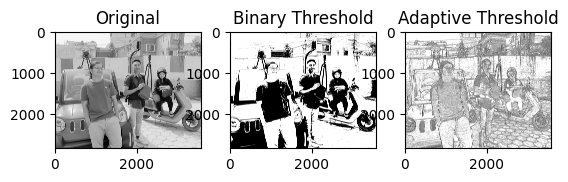

In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Read image in grayscale
img = cv2.imread('image.jpg', 0)

# Simple binary threshold
_, thresh = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY)

# Adaptive thresholding
adaptive_thresh = cv2.adaptiveThreshold(img, 255, 
                                        cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                        cv2.THRESH_BINARY, 11, 2)

plt.subplot(1,3,1), plt.imshow(img, cmap='gray'), plt.title('Original')
plt.subplot(1,3,2), plt.imshow(thresh, cmap='gray'), plt.title('Binary Threshold')
plt.subplot(1,3,3), plt.imshow(adaptive_thresh, cmap='gray'), plt.title('Adaptive Threshold')
plt.show()


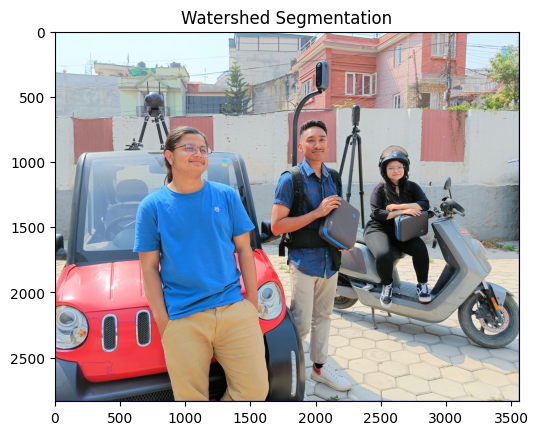

In [2]:
img = cv2.imread('image.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Sure background area
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Sure foreground area
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)
ret, sure_fg = cv2.threshold(dist_transform, 0.7*dist_transform.max(), 255, 0)

# Unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg, sure_fg)

# Marker labeling
ret, markers = cv2.connectedComponents(sure_fg)
markers = markers + 1
markers[unknown==255] = 0

# Apply Watershed
markers = cv2.watershed(img, markers)
img[markers == -1] = [255,0,0]  # mark boundaries in red

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Watershed Segmentation')
plt.show()


# K Means Segmentation

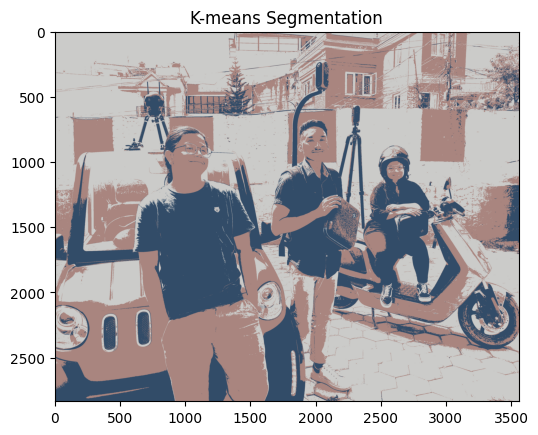

In [4]:
img = cv2.imread('image.jpg')
Z = img.reshape((-1,3))  # flatten image
Z = np.float32(Z)

# Define criteria, number of clusters(K) and apply kmeans
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 3
ret,label,center=cv2.kmeans(Z,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Convert back to uint8 and reshape
center = np.uint8(center)
res = center[label.flatten()]
res2 = res.reshape((img.shape))

plt.imshow(cv2.cvtColor(res2, cv2.COLOR_BGR2RGB))
plt.title('K-means Segmentation')
plt.show()


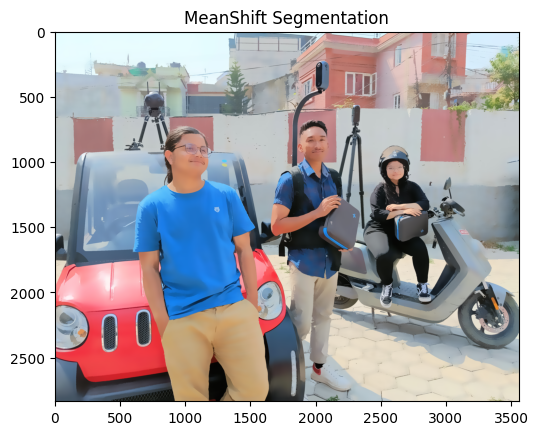

In [5]:
import cv2
import numpy as np

img = cv2.imread('image.jpg')
# Apply MeanShift
shifted = cv2.pyrMeanShiftFiltering(img, sp=20, sr=40)

plt.imshow(cv2.cvtColor(shifted, cv2.COLOR_BGR2RGB))
plt.title('MeanShift Segmentation')
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from sklearn.cluster import KMeans
from scipy import ndimage

# Load image
img = io.imread('image.jpg')
if img.shape[2] == 4:  # Remove alpha if exists
    img = img[:,:,:3]
gray = color.rgb2gray(img)  # Grayscale for thresholding

# ------------------------
# 1️⃣ Thresholding (Simple)
# ------------------------
def threshold_segmentation(gray_img, thresh=0.5):
    return (gray_img > thresh).astype(np.uint8)

thresh_seg = threshold_segmentation(gray)

# ------------------------
# 2️⃣ Region-based Segmentation (Flood Fill)
# ------------------------
def flood_fill_segmentation(gray_img, tolerance=0.05):
    h, w = gray_img.shape
    visited = np.zeros((h,w), dtype=bool)
    segments = []
    
    def flood_fill(x, y, region_val):
        stack = [(x,y)]
        region = []
        while stack:
            i,j = stack.pop()
            if i<0 or i>=h or j<0 or j>=w or visited[i,j]:
                continue
            if abs(gray_img[i,j] - region_val) < tolerance:
                visited[i,j] = True
                region.append((i,j))
                # 4-neighborhood
                stack.extend([(i+1,j),(i-1,j),(i,j+1),(i,j-1)])
        return region
    
    for i in range(h):
        for j in range(w):
            if not visited[i,j]:
                region_val = gray_img[i,j]
                region_pixels = flood_fill(i,j,region_val)
                if len(region_pixels) > 50:  # ignore tiny noise
                    segments.append(region_pixels)
    return segments

flood_segments = flood_fill_segmentation(gray)

# ------------------------
# 3️⃣ K-means Clustering
# ------------------------
def kmeans_segmentation(img, K=3):
    Z = img.reshape((-1,3))
    kmeans = KMeans(n_clusters=K, random_state=0).fit(Z)
    labels = kmeans.labels_.reshape(img.shape[:2])
    clusters = []
    for k in range(K):
        clusters.append((labels == k).astype(np.uint8))
    return clusters

kmeans_segments = kmeans_segmentation(img, K=3)

# ------------------------
# 4️⃣ MeanShift-like Segmentation (Simplified)
# ------------------------
def meanshift_segmentation(img, spatial_radius=5, color_radius=0.1, max_iter=10):
    h, w, c = img.shape
    img_normalized = img / 255.0
    segmented = img_normalized.copy()
    
    for iteration in range(max_iter):
        new_img = segmented.copy()
        for i in range(h):
            for j in range(w):
                # get neighbors in spatial radius
                i_min = max(i-spatial_radius,0)
                i_max = min(i+spatial_radius+1,h)
                j_min = max(j-spatial_radius,0)
                j_max = min(j+spatial_radius+1,w)
                window = segmented[i_min:i_max, j_min:j_max, :]
                
                # compute distance in color space
                color_diff = np.linalg.norm(window - segmented[i,j], axis=2)
                mask = color_diff < color_radius
                if np.any(mask):
                    new_img[i,j] = np.mean(window[mask], axis=0)
        segmented = new_img
    return (segmented*255).astype(np.uint8)

meanshift_seg = meanshift_segmentation(img, spatial_radius=3, color_radius=0.1, max_iter=5)

# ------------------------
# Plotting
# ------------------------
fig, axes = plt.subplots(2,4, figsize=(20,10))

# Original
axes[0,0].imshow(img)
axes[0,0].set_title('Original')
axes[0,0].axis('off')

# Threshold
axes[0,1].imshow(thresh_seg, cmap='gray')
axes[0,1].set_title('Threshold')
axes[0,1].axis('off')

# Flood-fill / Region
region_img = np.zeros_like(gray)
for idx, region in enumerate(flood_segments):
    for (i,j) in region:
        region_img[i,j] = idx/len(flood_segments)
axes[0,2].imshow(region_img, cmap='nipy_spectral')
axes[0,2].set_title('Region-based')
axes[0,2].axis('off')

# K-means clusters
for k in range(len(kmeans_segments)):
    axes[0,3].imshow(kmeans_segments[k], cmap='gray', alpha=0.5)
axes[0,3].imshow(img, alpha=0.3)
axes[0,3].set_title('K-means')
axes[0,3].axis('off')

# MeanShift
axes[1,0].imshow(meanshift_seg)
axes[1,0].set_title('MeanShift')
axes[1,0].axis('off')

plt.tight_layout()
plt.show()
